# PCA Mini-project

Our discussion of PCA spent a lot of time on theoretical issues, so in this mini-project we’ll ask you to play around with some sklearn code. The eigenfaces code is interesting and rich enough to serve as the testbed for this entire mini-project.

The starter code can be found in pca/eigenfaces.py. This was mostly taken from the example found here, on the sklearn documentation.

https://github.com/mudspringhiker/ud120-projects/blob/master/pca/eigenfaces.py

Take note when running the code, that there are changes in one of the parameters for the SVC function called on line 94 of pca/eigenfaces.py. For the 'class_weight' parameter, the argument string "auto" is a valid value for sklearn version 0.16 and prior, but will be depreciated by 0.19. If you are running sklearn version 0.17 or later, the expected argument string should be "balanced". If you get an error or warning when running pca/eigenfaces.py, make sure that you have the correct argument on line 98 that matches your installed version of sklearn.


Faces recognition example using eigenfaces and SVMs
The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:
  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)
  .. _LFW: http://vis-www.cs.umass.edu/lfw/
  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html



/Users/alonavarshal/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/alonavarshal/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
2016-12-13 20:10:25,810 Loading LFW people faces from /Users/alonavarshal/scikit_learn_data/lfw_home


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces


/Users/alonavarshal/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.478s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.056s
Fitting the classifier to the training set
done in 21.944s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.064s
                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.38      0.48        13
     Colin Powell       0.83      0.87      0.85        60
  Donald Rumsfeld       0.94      0.63      0.76        27
    George W Bush       0.82      0.98      0.89       146
Gerhard Schroeder       0.95      0.76      0.84        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       0.94      0.81      0.87        36

      avg / total       0.85      0.84      

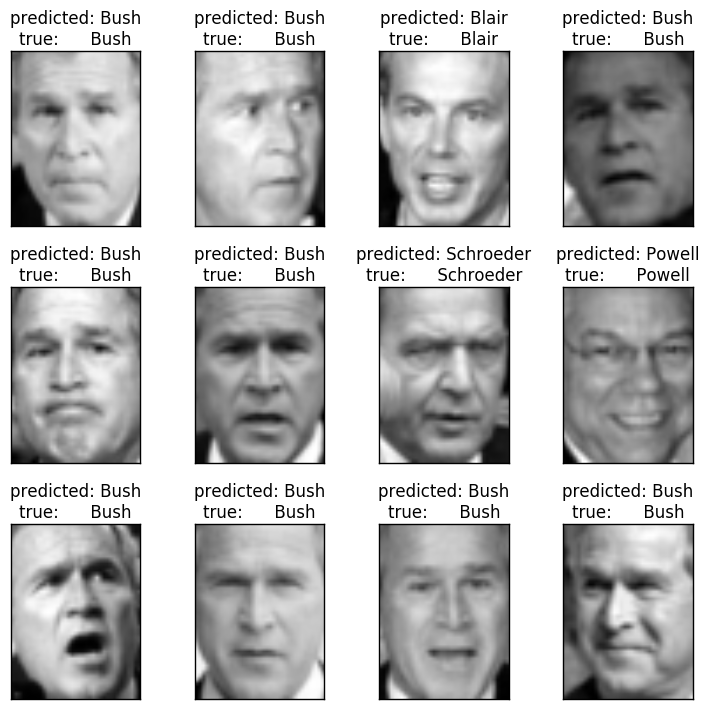

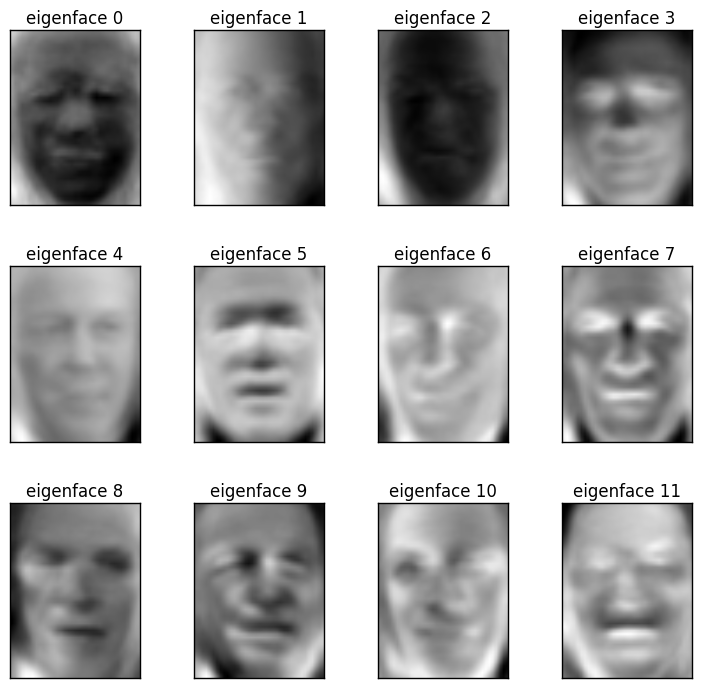

In [1]:
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================
The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:
  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)
  .. _LFW: http://vis-www.cs.umass.edu/lfw/
  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html
"""
print __doc__

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes


###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)


###############################################################################
# Train a SVM classification model

print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_


###############################################################################
# Quantitative evaluation of the model quality on the test set

print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

## Explained variance of each PC

We mentioned that PCA will order the principal components, with the first PC giving the direction of maximal variance, second PC has second-largest variance, and so on. How much of the variance is explained by the first principal component? The second?

In [4]:
pca.explained_variance_ratio_

array([ 0.19346474,  0.15116931,  0.07083688,  0.05952028,  0.05157574,
        0.02887213,  0.02514474,  0.02176463,  0.0201937 ,  0.01902118,
        0.01682174,  0.01580626,  0.01223351,  0.01087937,  0.01064428,
        0.00979671,  0.00892415,  0.00854861,  0.00835728,  0.00722644,
        0.00696579,  0.00653871,  0.00639546,  0.0056132 ,  0.00531101,
        0.00520166,  0.00507468,  0.0048421 ,  0.00443585,  0.00417818,
        0.00393683,  0.00381708,  0.00356072,  0.00351193,  0.00334548,
        0.00329931,  0.00314629,  0.002962  ,  0.00290118,  0.00284704,
        0.00279974,  0.00267531,  0.00259891,  0.00258369,  0.00240909,
        0.00238967,  0.00235398,  0.00222556,  0.00217475,  0.00216533,
        0.0020899 ,  0.00205381,  0.002004  ,  0.0019734 ,  0.00193799,
        0.0018871 ,  0.00180118,  0.00178831,  0.00174794,  0.00172991,
        0.00165608,  0.00162908,  0.00157362,  0.0015332 ,  0.00149874,
        0.00147131,  0.00143766,  0.00141792,  0.00139588,  0.00

<- First component variance ratio: 0.193, second: 0.1512

## How many PCs to Use?

Now you'll experiment with keeping different numbers of principal components. In a multiclass classification problem like this one (more than 2 labels to apply), accuracy is a less-intuitive metric than in the 2-class case. Instead, a popular metric is the F1 score.

We’ll learn about the F1 score properly in the lesson on evaluation metrics, but you’ll figure out for yourself whether a good classifier is characterized by a high or low F1 score. You’ll do this by varying the number of principal components and watching how the F1 score changes in response.

As you add more principal components as features for training your classifier, do you expect it to get better or worse performance?

 - could go either better or worse
 
While ideally, adding components should provide us additional signal to improve our performance, it is possible that we end up at a complexity where we overfit.

## F1 Score vs. No. of PCs Used

Change n_components to the following values: [10, 15, 25, 50, 100, 250]. For each number of principal components, note the F1 score for Ariel Sharon. (For 10 PCs, the plotting functions in the code will break, but you should be able to see the F1 scores.) If you see a higher F1 score, does it mean the classifier is doing better, or worse?

- Higher F1 score meanes classifier is doing better

2016-12-13 21:39:29,428 Loading LFW people faces from /Users/alonavarshal/scikit_learn_data/lfw_home



Faces recognition example using eigenfaces and SVMs
The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:
  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)
  .. _LFW: http://vis-www.cs.umass.edu/lfw/
  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 100 eigenfaces from 966 faces


/Users/alonavarshal/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.249s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.044s
Fitting the classifier to the training set
done in 15.621s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.058s
                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.69      0.67        13
     Colin Powell       0.79      0.90      0.84        60
  Donald Rumsfeld       0.81      0.63      0.71        27
    George W Bush       0.88      0.95      0.91       146
Gerhard Schroeder       0.91      0.84      0.87        25
      Hugo Chavez       0.90      0.60      0.72        15
       Tony Blair       0.90      0.72      0.80        36

      avg / total       0.85      0.85      

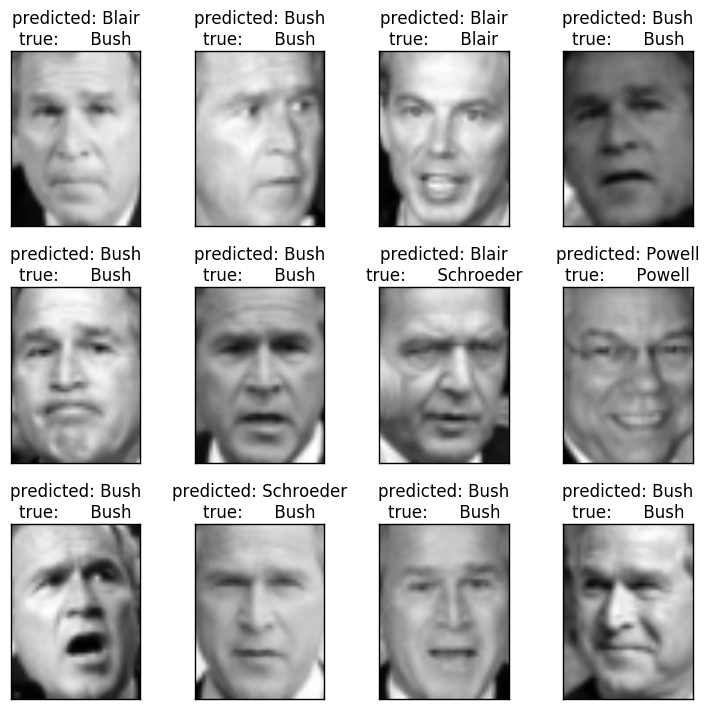

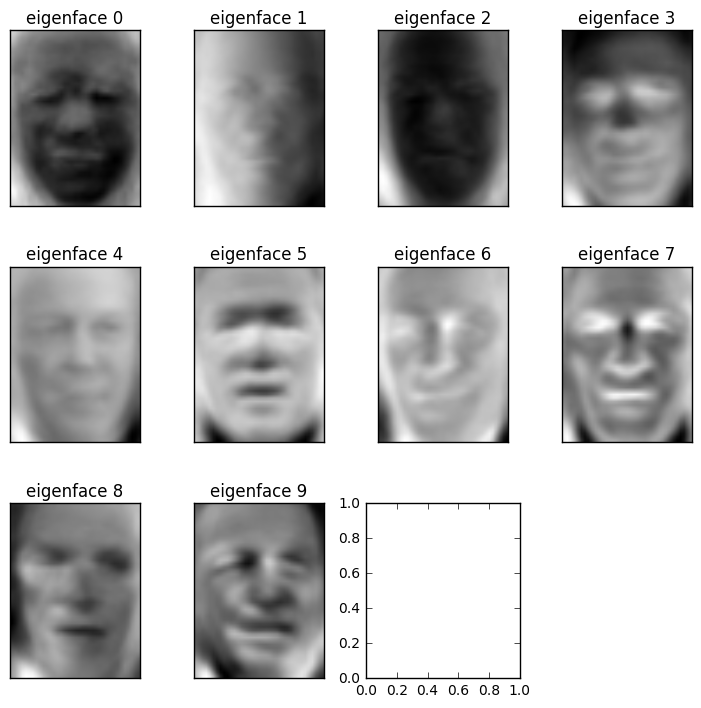

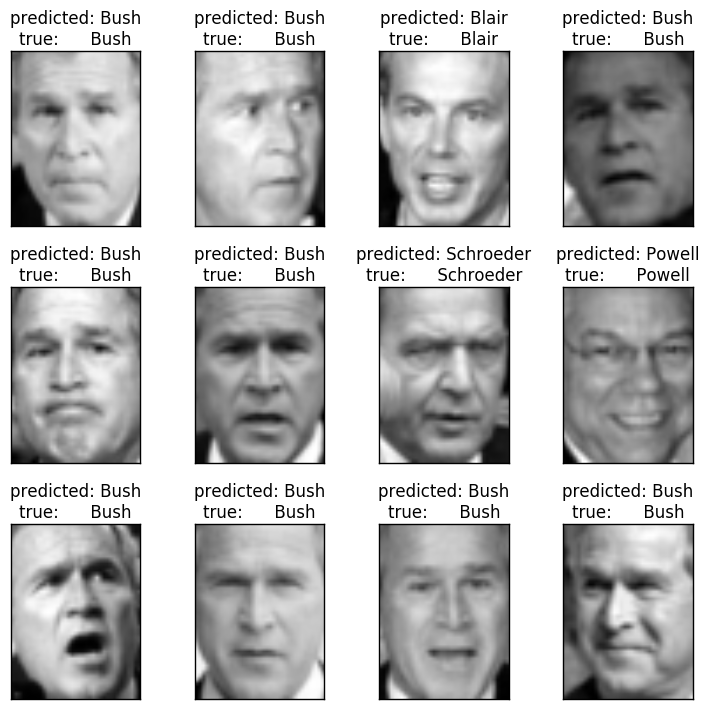

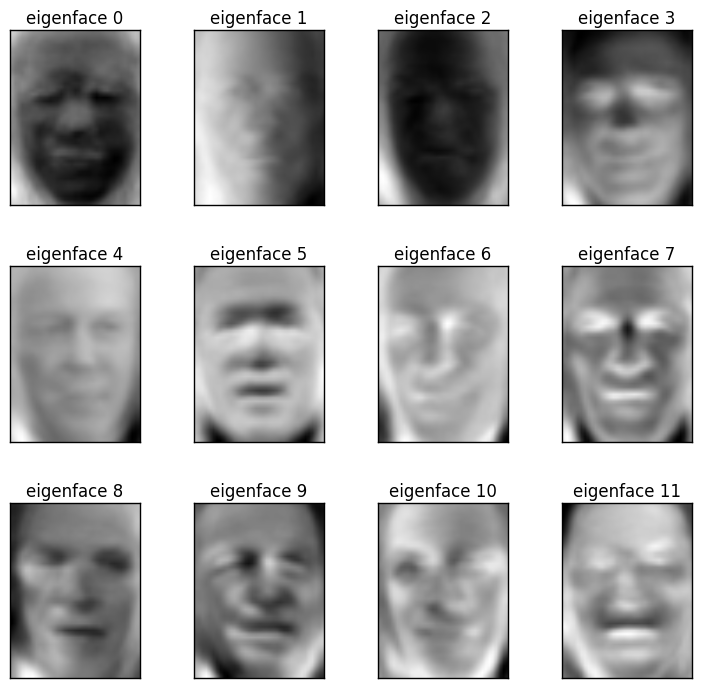

In [9]:
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================
The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:
  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)
  .. _LFW: http://vis-www.cs.umass.edu/lfw/
  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html
"""
print __doc__

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes


###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 100

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)


###############################################################################
# Train a SVM classification model

print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_


###############################################################################
# Quantitative evaluation of the model quality on the test set

print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

In [10]:
pca.explained_variance_ratio_

array([ 0.19346474,  0.15116931,  0.07083688,  0.05952028,  0.05157574,
        0.02887213,  0.02514474,  0.02176463,  0.0201937 ,  0.01902117,
        0.01682174,  0.01580626,  0.01223351,  0.01087936,  0.01064427,
        0.0097967 ,  0.00892413,  0.00854857,  0.00835725,  0.00722635,
        0.00696574,  0.00653863,  0.00639538,  0.00561312,  0.00531081,
        0.00520132,  0.00507433,  0.00484193,  0.00443549,  0.00417775,
        0.00393615,  0.00381678,  0.00356017,  0.00351098,  0.00334459,
        0.00329724,  0.00314567,  0.0029596 ,  0.00289873,  0.00284404,
        0.00279892,  0.00267338,  0.00259595,  0.00258053,  0.00240677,
        0.0023816 ,  0.00235046,  0.00222074,  0.00216747,  0.0021596 ,
        0.00208754,  0.00204728,  0.00199725,  0.00196997,  0.00193214,
        0.00188005,  0.001788  ,  0.00178053,  0.0017368 ,  0.00172124,
        0.0016473 ,  0.00161484,  0.00153561,  0.00150672,  0.00148322,
        0.00145074,  0.00140871,  0.00138922,  0.00137862,  0.00

2016-12-13 21:44:47,989 Loading LFW people faces from /Users/alonavarshal/scikit_learn_data/lfw_home



Faces recognition example using eigenfaces and SVMs
The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:
  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)
  .. _LFW: http://vis-www.cs.umass.edu/lfw/
  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 50 eigenfaces from 966 faces


/Users/alonavarshal/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.195s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.033s
Fitting the classifier to the training set
done in 8.504s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.027s
                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.69      0.67        13
     Colin Powell       0.82      0.88      0.85        60
  Donald Rumsfeld       0.68      0.56      0.61        27
    George W Bush       0.87      0.90      0.89       146
Gerhard Schroeder       0.73      0.76      0.75        25
      Hugo Chavez       0.79      0.73      0.76        15
       Tony Blair       0.86      0.69      0.77        36

      avg / total       0.82      0.82      0.

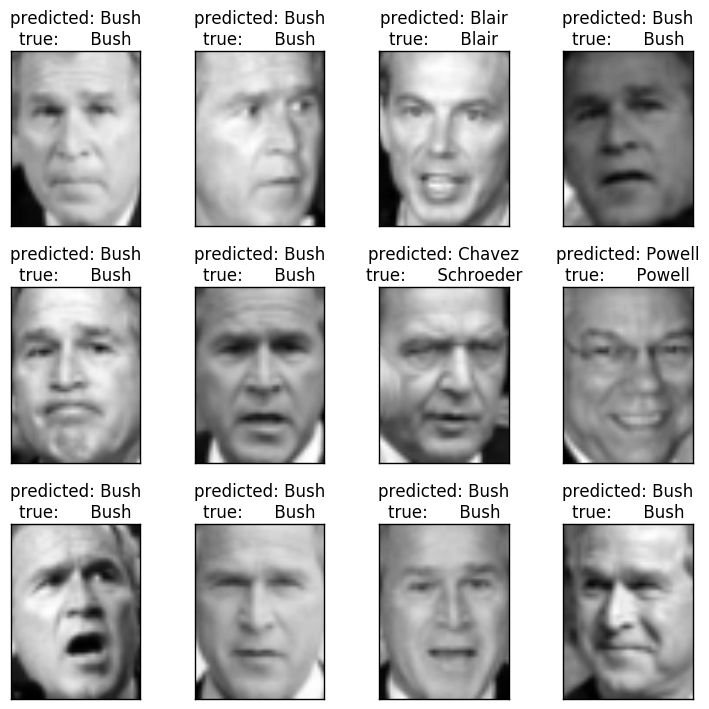

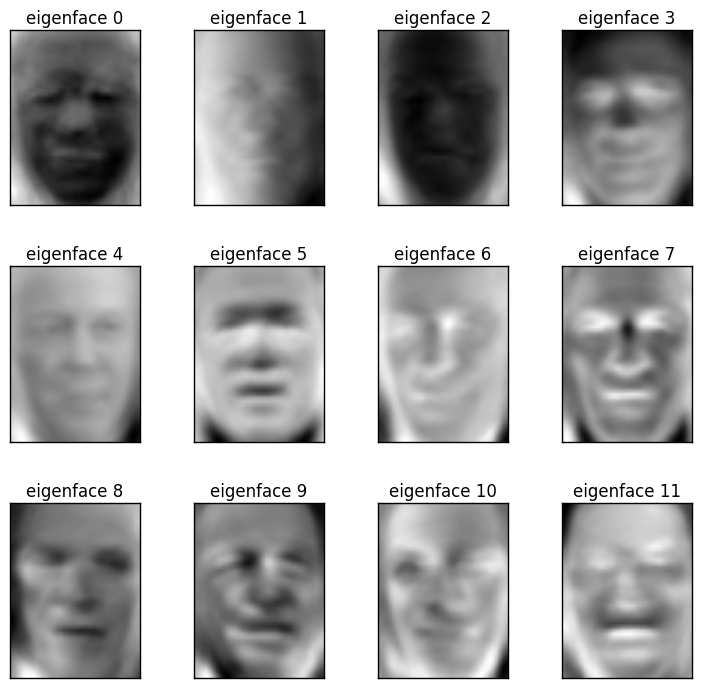

In [11]:
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================
The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:
  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)
  .. _LFW: http://vis-www.cs.umass.edu/lfw/
  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html
"""
print __doc__

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes


###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 50

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)


###############################################################################
# Train a SVM classification model

print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_


###############################################################################
# Quantitative evaluation of the model quality on the test set

print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

In [12]:
pca.explained_variance_ratio_

array([ 0.19346474,  0.15116931,  0.07083688,  0.05952028,  0.05157574,
        0.02887212,  0.0251447 ,  0.02176457,  0.02019357,  0.01902103,
        0.01682157,  0.01580595,  0.01223271,  0.01087802,  0.01064326,
        0.00979535,  0.00892235,  0.00854726,  0.00835452,  0.00722213,
        0.0069639 ,  0.00652887,  0.00638106,  0.00557994,  0.00526995,
        0.00517938,  0.00506204,  0.00482846,  0.0044017 ,  0.00415735,
        0.00390854,  0.00376334,  0.00349335,  0.0034316 ,  0.00329316,
        0.00319466,  0.00310593,  0.0028506 ,  0.00283283,  0.00273134,
        0.00266368,  0.00255775,  0.00250068,  0.00241513,  0.00229424,
        0.00223053,  0.00211663,  0.00206255,  0.00202451,  0.00201408])

2016-12-13 21:53:36,193 Loading LFW people faces from /Users/alonavarshal/scikit_learn_data/lfw_home



Faces recognition example using eigenfaces and SVMs
The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:
  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)
  .. _LFW: http://vis-www.cs.umass.edu/lfw/
  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 250 eigenfaces from 966 faces


/Users/alonavarshal/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.517s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.084s
Fitting the classifier to the training set
done in 49.471s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.102s
                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.69      0.60        13
     Colin Powell       0.75      0.93      0.83        60
  Donald Rumsfeld       0.89      0.59      0.71        27
    George W Bush       0.92      0.90      0.91       146
Gerhard Schroeder       0.83      0.80      0.82        25
      Hugo Chavez       0.80      0.53      0.64        15
       Tony Blair       0.78      0.78      0.78        36

      avg / total       0.84      0.83      

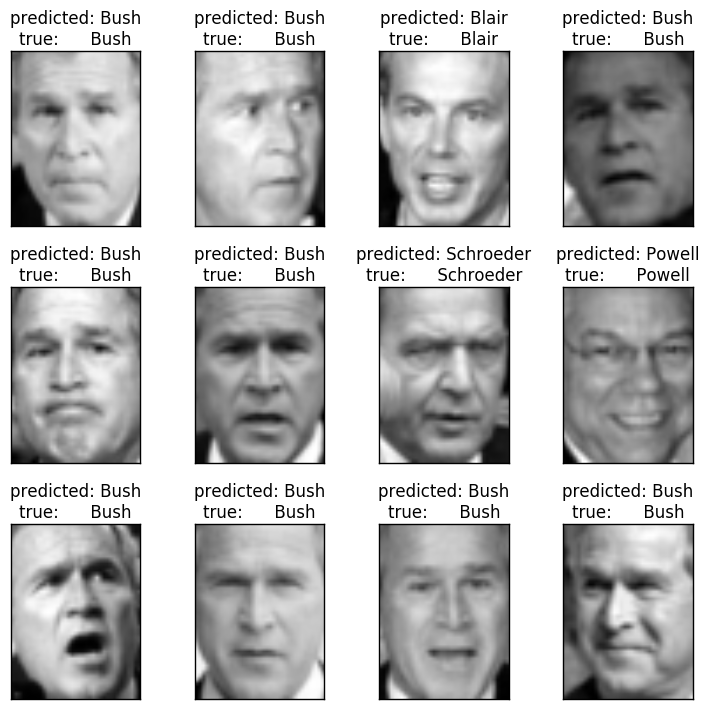

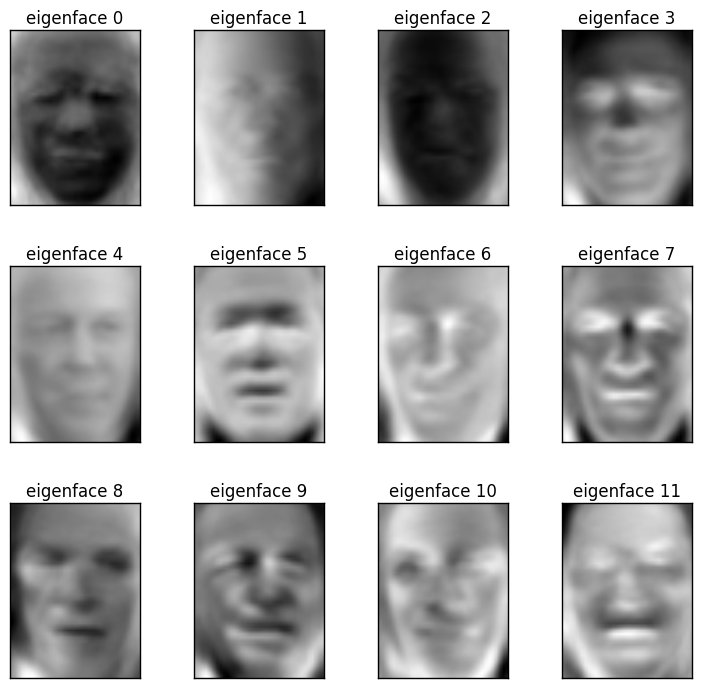

In [13]:
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================
The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:
  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)
  .. _LFW: http://vis-www.cs.umass.edu/lfw/
  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html
"""
print __doc__

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes


###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 250

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)


###############################################################################
# Train a SVM classification model

print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_


###############################################################################
# Quantitative evaluation of the model quality on the test set

print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

# It is important to remember that F1 - score refers to the SVC process after PCA. The explained variances of the principal components should not change. Changing the number of PCs should not change the pc scores, but changing the number of PCs will affect the SVC, hence the change in F1-scores.

## Dimensionality Reduction and Overfitting

Do you see any evidence of overfitting when using a large number of PCs? Does the dimensionality reduction of PCA seem to be helping your performance here?

- performance drops with increasing number of PCs (F1 score starts to drop)

## Selecting Principal components

- train on different number of PCs, and see how many accuracy responds --cut off when it becomes apparent that adding more PCs doesnt buy you much more discrimination

Do not do feature selection before PCA!!! PCA --> latent features that combines original features.